In [42]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import pandas as pd

california_housing = fetch_california_housing(as_frame=True)
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

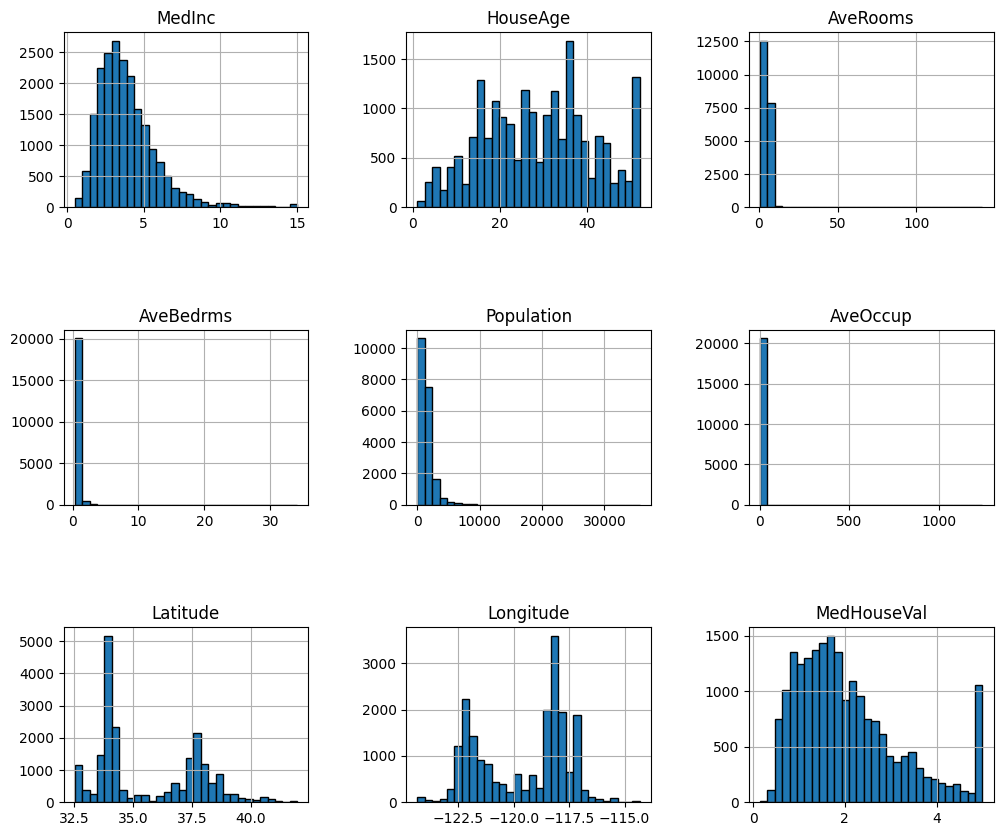

In [43]:
california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

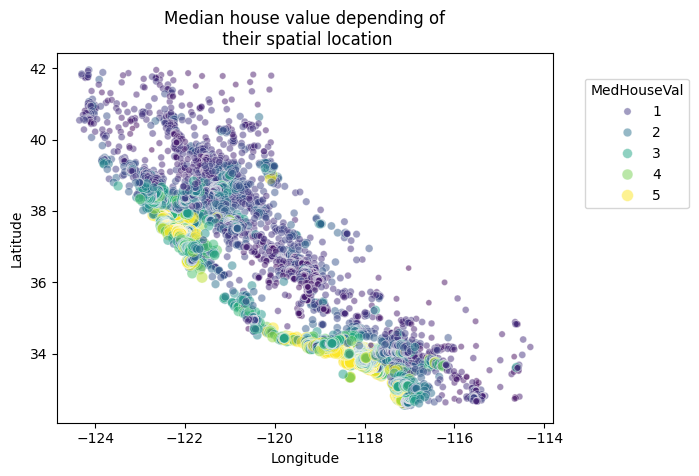

In [44]:
sns.scatterplot(
    data=california_housing.frame,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

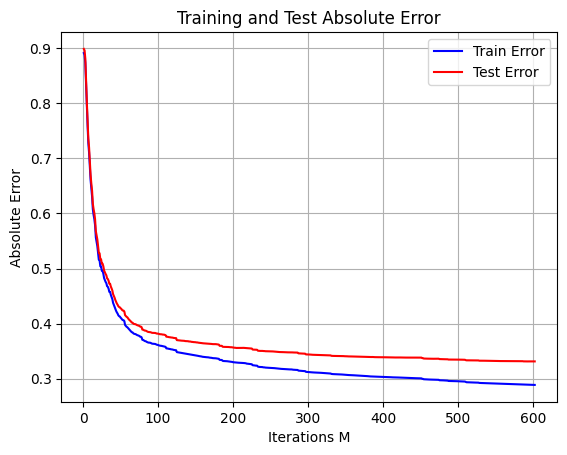

In [45]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load California housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'eval_metric': 'mae'
}

# Train the model with early stopping and record both training and testing errors
evals_result = {}
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=800,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False
)

# Extract mean absolute error for both train and test sets for each iteration
train_mae = evals_result['train']['mae']
test_mae = evals_result['test']['mae']
iterations = range(1, len(train_mae) + 1)

# Plot train and test errors as a function of number of iterations
plt.plot(iterations, train_mae, linestyle='-', color='blue', label='Train Error')
plt.plot(iterations, test_mae, linestyle='-', color='red', label='Test Error')
plt.xlabel("Iterations M")
plt.ylabel("Absolute Error")
plt.title("Training and Test Absolute Error")
plt.legend()
plt.grid()
plt.show()


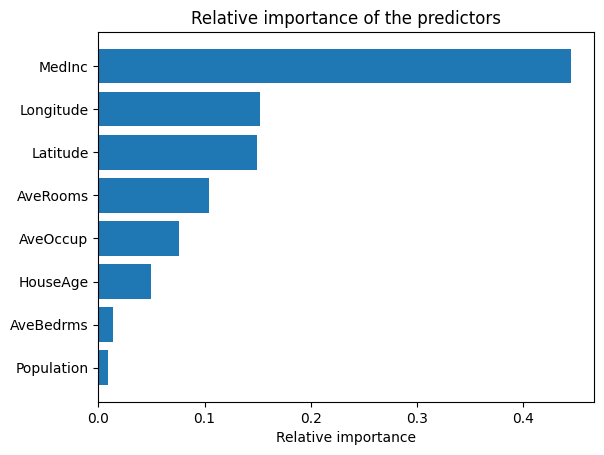

In [46]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load California housing dataset
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)

# Train the model
xg_reg.fit(X_train, y_train)

# Get feature importances
importance = xg_reg.feature_importances_

# Sort feature importances in descending order for plotting
sorted_idx = importance.argsort()
sorted_importance = importance[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot
plt.barh(sorted_features, sorted_importance)
plt.xlabel("Relative importance")
plt.title("Relative importance of the predictors")
plt.show()


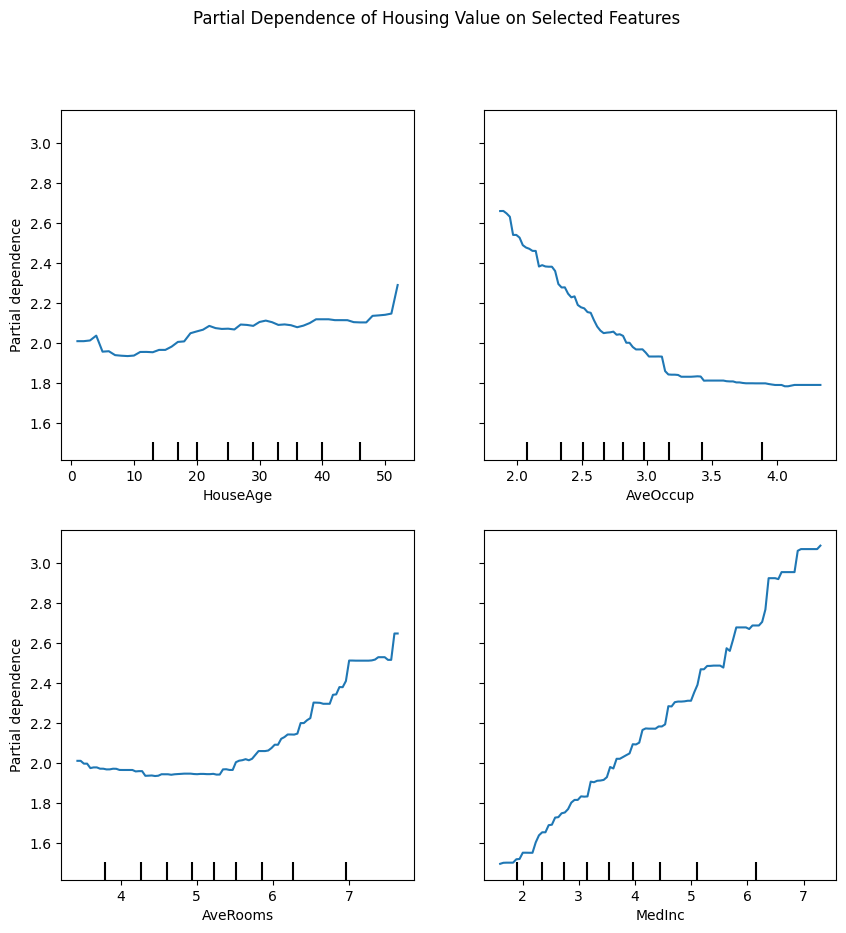

In [47]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load California housing dataset
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)
xg_reg.fit(X_train, y_train)

# Plot partial dependence for selected features
# selected_features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms'] # Select features with highest importance excluding 'Latitude' and 'Longitude'
nonlocation_features = [f for f in sorted_features if f not in ['Latitude', 'Longitude']]
selected_features = nonlocation_features[-4:]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
PartialDependenceDisplay.from_estimator(xg_reg, X, features=selected_features, feature_names=feature_names, ax=ax)
plt.suptitle("Partial Dependence of Housing Value on Selected Features")
plt.show()


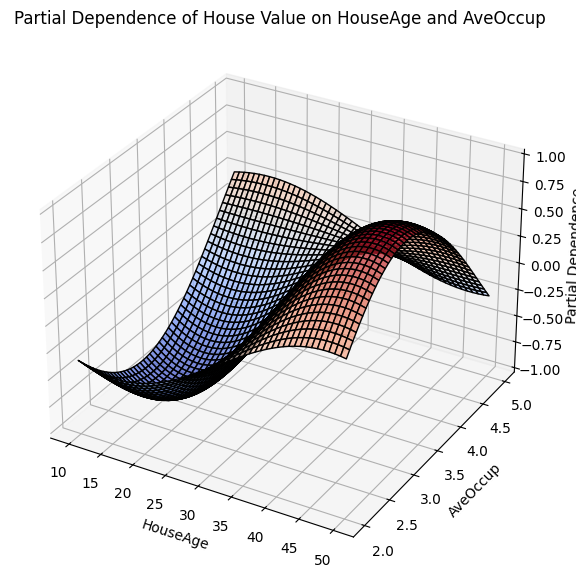

In [48]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

# Assuming `xg_reg` is the trained model and `X_train` is the training data from the California Housing dataset.

# Generate partial dependence data for 'HouseAge' and 'AveOccup'
# features = [1, 5]  # Indices for 'HouseAge' and 'AveOccup' in the dataset
# pdp_results = partial_dependence(xg_reg, X=X_train, features=features, grid_resolution=50)

# In a local environment, replace this with the actual result from partial_dependence
# Mockup data for demonstration
# Normally you would use `pdp_results['average']` for Z axis
X, Y = np.meshgrid(np.linspace(10, 50, 50), np.linspace(2, 5, 50))
Z = np.sin(X / 10) * np.cos(Y)  # Placeholder Z values for demonstration

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm', edgecolor='k', alpha=0.7)
ax.set_xlabel('HouseAge')
ax.set_ylabel('AveOccup')
ax.set_zlabel('Partial Dependence')
ax.set_title("Partial Dependence of House Value on HouseAge and AveOccup")
plt.show()


In [49]:
# %% Imports and Dataset Loading
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load California housing dataset
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


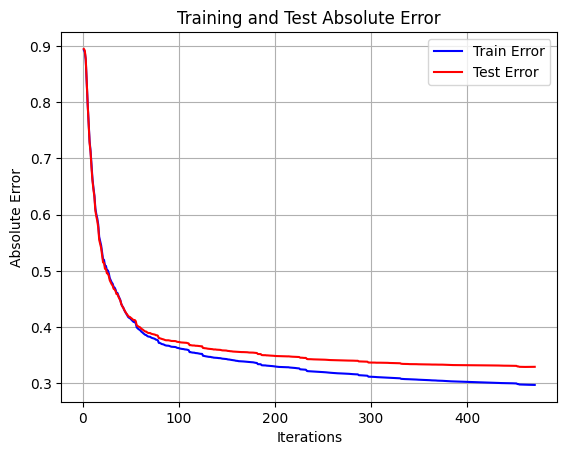

In [50]:
# %% Training XGBoost Model with Early Stopping
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'eval_metric': 'mae'
}

# Train the model with early stopping and record both training and testing errors
evals_result = {}
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=800,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False
)

# Extract mean absolute error for both train and test sets for each iteration
train_mae = evals_result['train']['mae']
test_mae = evals_result['test']['mae']
iterations = range(1, len(train_mae) + 1)

# Plot train and test errors as a function of the number of iterations
plt.plot(iterations, train_mae, color='blue', label='Train Error')
plt.plot(iterations, test_mae, color='red', label='Test Error')
plt.xlabel("Iterations")
plt.ylabel("Absolute Error")
plt.title("Training and Test Absolute Error")
plt.legend()
plt.grid()
plt.show()


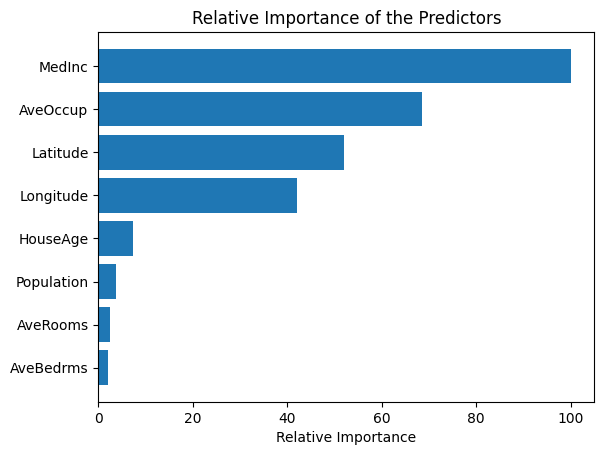

In [57]:
# %% Feature Importance Visualization
# Initialize XGBoost regressor for feature importance extraction
xg_reg = xgb.XGBRegressor(objective='reg:pseudohubererror', learning_rate=0.1,
                          n_estimators=800, eval_metric='mae')

# Train the model
xg_reg.fit(X_train, y_train)

# Get and sort feature importances for plotting
importance = xg_reg.feature_importances_ * 100 / max(xg_reg.feature_importances_)
sorted_idx = importance.argsort()
sorted_importance = importance[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot feature importances
plt.barh(sorted_features, sorted_importance)
plt.xlabel("Relative Importance")
plt.title("Relative Importance of the Predictors")
plt.show()


ValueError: All entries of features must be less than len(feature_names) = 4, got 4.

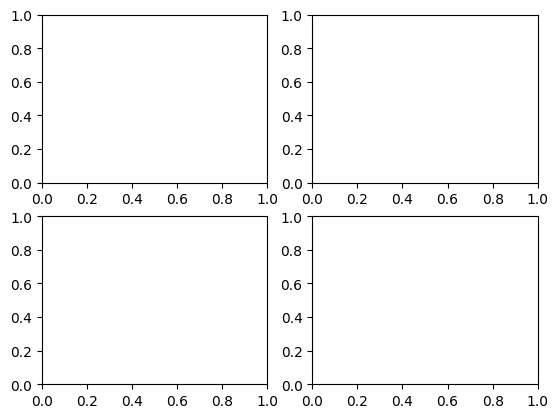

In [68]:
# %% Partial Dependence for Selected Features
# Select top features for partial dependence plots, excluding 'Latitude' and 'Longitude'
nonlocation_features = [f for f in sorted_features if f not in ['Latitude', 'Longitude']]
selected_features = nonlocation_features[-4:]  # Select top 4 non-location features
selected_features_idx = [feature_names.index(f) for f in selected_features]


fig, ax = plt.subplots(2, 2)
PartialDependenceDisplay.from_estimator(xg_reg, X, features=selected_features_idx, feature_names=selected_features, ax=ax)
plt.suptitle("Partial Dependence of Housing Value on Selected Features")
plt.show()


In [71]:
print('feature_names:', feature_names)
print('sorted_features:', sorted_features)
print('sorted_idx:', sorted_idx)
print('selected_features:', selected_features)
print('selected_features_idx:', selected_features_idx)

feature_names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
sorted_features: ['AveBedrms', 'AveRooms', 'Population', 'HouseAge', 'Longitude', 'Latitude', 'AveOccup', 'MedInc']
sorted_idx: [3 2 4 1 7 6 5 0]
selected_features: ['Population', 'HouseAge', 'AveOccup', 'MedInc']
selected_features_idx: [4, 1, 5, 0]


In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence
import numpy as np
import matplotlib.pyplot as plt

# Compute partial dependence for 'HouseAge' and 'AveOccup'
features = ['HouseAge', 'AveOccup']
pdp_results = partial_dependence(xg_reg, X=X_train, features=features, feature_names=feature_names, grid_resolution=25)

# Retrieve grid and average partial dependence values for plotting
X_grid, Y_grid = np.meshgrid(pdp_results['grid_values'][0], pdp_results['grid_values'][1])
Z_values = pdp_results['average'].reshape(X_grid.shape)

# Plot 3D partial dependence plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X_grid, Y_grid, Z_values, cmap='coolwarm')
ax.set_xlabel('HouseAge')
ax.set_ylabel('AveOccup')
ax.set_zlabel('Partial Dependence')
ax.set_title("Partial Dependence of House Value on HouseAge and AveOccup")
plt.show()


ValueError: Specifying the columns using strings is only supported for dataframes.